In [32]:
import yfinance as yf
import pickle
from lstm_model import LSTM
import torch
from sklearn.preprocessing import MinMaxScaler

import json

import matplotlib.font_manager as fm
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import yfinance as yf

from scripts.config import FONT_PATH
from lstm_model import LSTM
from scripts.utils import get_train_test_sets

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [40]:
df = pd.DataFrame()

tickers = {
    'bitcoin': 'BTC-USD',
    'solana': 'SOL-USD',
    'raydium': 'RAY-USD',
    'orca': 'ORCA-USD',
    'ethereum': 'ETH-USD',
    'uniswap': 'UNI7083-USD'
    }

for name, ticker in tickers.items():
    print(name)
    # Download data
    raw_price_data = yf.download(ticker, start='2020-01-01', end='2024-03-31', progress=False)

    # Normalize data
    scaler = MinMaxScaler()
    normalized_price_data = scaler.fit_transform(raw_price_data['Close'].values.reshape(-1, 1))

    # Model parameters
    input_size = 5
    hidden_layer_size = 250
    output_size = 1

    # Load model
    file_path = f'models/lstm_{name}.pkl'
    model = LSTM(input_size, hidden_layer_size, output_size)
    model.load_state_dict(torch.load(file_path))
    
    # Create a tensor for the entire data
    x_all = torch.from_numpy(normalized_price_data.astype(np.float32)).view(-1, 1)

    # Predict the prices using a sliding window
    y_all_pred = []
    for i in range(5, len(x_all)):
        x = x_all[i-5:i].view(1, 5, 1)
        y_pred = model.test_model(x)
        y_all_pred.append(y_pred.item())

    # Convert to numpy array and reshape
    y_all_pred = np.array(y_all_pred).reshape(-1, 1)

    # Inverse transform to get actual prices
    y_all_pred = scaler.inverse_transform(y_all_pred)
    y_all = scaler.inverse_transform(normalized_price_data[5:])

    df[name] = raw_price_data['Close']
    df[f'{name}_predicted'] = np.insert(y_all_pred, 0, [[np.nan]]*(len(df) - len(y_all_pred)), axis=0)

bitcoin
solana
raydium
orca
ethereum
uniswap


In [41]:
# Read the data
df_tvl = pd.read_csv('./data/chain-dataset-Solana.csv')

# Filter for 'Raydium' and 'Orca'
df_tvl = df_tvl[df_tvl['Protocol'].isin(['Raydium', 'Orca'])].T

# Drop first row and convert index to datetime
df_tvl.drop(df_tvl.index[0], inplace=True)
df_tvl.index = pd.to_datetime(df_tvl.index, format='%d/%m/%Y')

# Rename columns
df_tvl.columns = ['raydium_tvl', 'orca_tvl']

# Drop NaN values
df_tvl.dropna(inplace=True)

# Merge the dataframes
df['raydium_tvl'] = df_tvl['raydium_tvl']
df['orca_tvl'] = df_tvl['orca_tvl']

In [82]:
# Select the columns to use in the model
model_data = df[['bitcoin_predicted', 'solana', 'raydium_predicted', 'raydium_tvl', 'ethereum_predicted', 'uniswap_predicted']].dropna()

# Split the data into input (X) and output (y) variables
X = model_data.drop('solana', axis=1)
y = model_data['solana']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create the MLP model
model = MLPRegressor(hidden_layer_sizes=(50, 50), learning_rate_init=0.001, max_iter=1500, random_state=42)

# Train the model
model.fit(X_train, y_train)

MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=1500, random_state=42)

In [83]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Make predictions for the test set
y_pred = model.predict(X_test)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R^2 Score: {r2}")

Mean Absolute Error (MAE): 4.6725293649694555
Mean Squared Error (MSE): 41.72202658641535
R^2 Score: 0.9862472406077132


In [84]:
X_all = scaler.transform(X)
y_all_pred = model.predict(X_all)
y_all_pred = pd.Series(y_all_pred.flatten(), index=y.index)

mae_all = mean_absolute_error(y, y_all_pred)
mse_all = mean_squared_error(y, y_all_pred)
r2_all = r2_score(y, y_all_pred)

print(f"Mean Absolute Error (MAE) for all data: {mae_all}")
print(f"Mean Squared Error (MSE) for all data: {mse_all}")
print(f"R^2 Score for all data: {r2_all}")

Mean Absolute Error (MAE) for all data: 4.394805097878702
Mean Squared Error (MSE) for all data: 42.257334384216
R^2 Score for all data: 0.9870349739503836


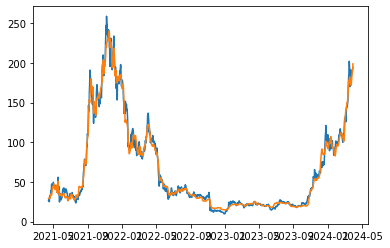

In [85]:
plt.plot(y, label='Actual')
plt.plot(y_all_pred, label='Predicted')

In [86]:
# Initialize variables
capital = 10000  # starting capital
in_trade = False
trades = []
symbol = 'SOL-USD'  # replace with your symbol

# Iterate over the data
for i in range(1, len(y)):
    # If we predict the price will go up tomorrow and we're not already in a trade
    if y_all_pred[i] > y[i-1] and not in_trade:
        # Enter the trade
        in_trade = True
        entry_price = y[i]
        entry_date = y.index[i]
        quantity = capital / entry_price  # calculate quantity
    # If we predict the price will go down tomorrow and we're in a trade
    elif y_all_pred[i] < y[i-1] and in_trade:
        # Exit the trade
        in_trade = False
        exit_price = y[i]
        exit_date = y.index[i]
        # Calculate return
        trade_return = np.log(exit_price / entry_price) / (exit_date - entry_date).days * 100
        # Add trade to list
        trades.append([entry_date, symbol, quantity, entry_price, exit_date, exit_price, trade_return, trade_return])

# Create DataFrame
trades_df = pd.DataFrame(trades, columns=['Entry Date', 'Symbol', 'Quantity', 'Entry Price', 'Exit Date', 'Exit Price', 'Return', 'Return per Trade Day'])
trades_df['Return (USD)'] = trades_df['Quantity'] * (trades_df['Exit Price'] - trades_df['Entry Price'])

In [87]:
# Number of trades
num_trades = len(trades_df)

# Number of profitable trades
num_profitable_trades = len(trades_df[trades_df['Return'] > 0])

# Number of losing trades
num_losing_trades = len(trades_df[trades_df['Return'] < 0])

# Average return of profitable trades
avg_return_profitable_trades = trades_df[trades_df['Return'] > 0]['Return'].mean()

# Average return of losing trades
avg_return_losing_trades = trades_df[trades_df['Return'] < 0]['Return'].mean()

# Overall average return
avg_return = trades_df['Return'].mean()

print(f"Number of trades: {num_trades}")
print(f"Number of profitable trades: {num_profitable_trades}")
print(f"Number of losing trades: {num_losing_trades}")
print(f"Average return of profitable trades: {avg_return_profitable_trades}")
print(f"Average return of losing trades: {avg_return_losing_trades}")
print(f"Overall average return: {avg_return}")

Number of trades: 93
Number of profitable trades: 58
Number of losing trades: 35
Average return of profitable trades: 3.4575284215028423
Average return of losing trades: -2.982051784384498
Overall average return: 1.0340304945559944


In [88]:
trades_df

,Entry Date,Symbol,Quantity,Entry Price,Exit Date,Exit Price,Return,Return per Trade Day,Return (USD)
0,2021-04-15,SOL-USD,359.475421,27.818314,2021-04-19,31.675896,3.246536,3.246536,1386.705948
1,2021-04-21,SOL-USD,307.568878,32.513042,2021-04-23,36.978420,6.434660,6.434660,1373.411244
2,2021-04-30,SOL-USD,232.796343,42.956001,2021-05-02,46.890987,4.382456,4.382456,916.050376
3,2021-05-03,SOL-USD,217.705135,45.933689,2021-05-04,42.729557,-7.230793,-7.230793,-697.556008
4,2021-05-12,SOL-USD,235.530703,42.457310,2021-05-13,40.997852,-3.497941,-3.497941,-343.747027
...,...,...,...,...,...,...,...,...,...
88,2024-02-05,SOL-USD,104.658715,95.548660,2024-02-07,100.979279,2.763984,2.763984,568.361531
89,2024-02-17,SOL-USD,91.756574,108.984016,2024-02-19,111.485329,1.134588,1.134588,229.511844
90,2024-02-21,SOL-USD,95.124651,105.125221,2024-02-25,103.453491,-0.400752,-0.400752,-159.022737
91,2024-03-03,SOL-USD,76.657214,130.450867,2024-03-15,182.964691,2.819138,2.819138,4025.563478


In [89]:
sum(trades_df['Return (USD)'])

65609.93189999898